# Documentation

#### Optimal Policy for hire-cost=1, wom dist uniform-int [0, 4], men dist uniform-int [1, 5]

state index | gender | productivity score | action | note
--- | --- | --- | --- | ---
0 | F | 0 | Reject |
1 | F | 1 | Reject |
2 | F | 2 | Hire |
3 | F | 3 | Hire |
4 | F | 4 | Hire | Unreachable state
5 | M | 0 | Reject | Unreachable state
6 | M | 1 | Reject | 
7 | M | 2 | Reject |
8 | M | 3 | Hire |
9 | M | 4 | Hire |

#### Computing expected reward per episode for optimal policy

Men 50th percentile = 2.5  
Women 50th percentile = 1.5
Hiring Cost = 1

```
50% of time gender = male:
    50% of time the value will be lower than threshold => not hire => 0
    50% of time the value will be greater than threshold => hire => exp prod score of 3.5 => 3.5-1=2.5

50% of time gender = female:
    50% of time the value will be lower than threshold => not hire => 0
    50% of time the value will be greater than threshold => hire => exp prod score of 2.5 => 2.5-5=1.5
    
exp_rew_per_ep = (.5)((.50)(0) + (.50)(2.5)) + (.5)((.50)(0) + (.50)(1.5))
               = 1.0

Python code
-----------
>>> exp_rew_per_ep = (.5)*((.50)*(0) + (.50)*(2.5)) + (.5)*((.50)*(0) + (.50)*(1.5))
>>> 100*exp_rew_per_ep
```

# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys

"""
Add gym-hiring directory to current path. I believe this is needed
when referencing a pip "file:///" dependency.
"""
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.insert(0, p)

import gym
import gym_hiring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.gym_utils import play_n_episodes

# Define Optimal Policy

In [2]:
class OptimalFairHiringPolicy:
    
    def __init__(self, gender_50, observation_function):
        self.gender_50 = gender_50
        self.observation_function = observation_function
        self._compute_policy()
    
    def select_action(self, obs, eps):
        # Get observation index
        obs_index = None
        for i, _obs in enumerate(self.observation_function):
            if obs == _obs:
                obs_index = i
                break

        if obs_index is None:
            raise Exception(f'Could not map observtion {obs} to action.')
        if self.policy is None:
            raise Exception('Must compute policy prior to selecting an action.')
            
        return self.policy[obs_index]
    
    def _compute_policy(self):
        """
        Computes policy as an array of actions.
        """
        self.policy = np.zeros(len(self.observation_function), dtype=int)

        for i, obs in enumerate(self.observation_function):
            action = self._best_action(obs)
            self.policy[i] = action
            
    def _best_action(self, obs):
        gender = obs[0]
        prod_score = obs[1]
        
        # Hiring threshold is set to the 50th percentile of each
        # gender's Productivy Score.
        thresh = self.gender_50[gender]
            
        if prod_score >= thresh:
            action = 1
        else:
            action = 0
        
        return action
    
    def add_experience(self, prev_obs, action, reward, obs, done):
        pass
    
    def train(self, iters):
        pass
    
    
# Alternatively, since the entire state space is discrete, we
# can write the optimal policy by defining a state-action map
# for all states.

# Array indices represent states. Values represent actions.
# >>> opt_policy = [0, 0, 1, 1, 1,
# >>>              0, 0, 0, 1, 1]

# Execute Optimal Policy

In [3]:
MEN_LOW = 1
MEN_HIGH = 5
WOM_LOW = 0
WOM_HIGH = 4

men_50th = (.50*(MEN_HIGH-1 - MEN_LOW))+ MEN_LOW
wom_50th = (.50*(WOM_HIGH-1 - WOM_LOW))+ WOM_LOW

observation_function = [
    [0, 0],  # gender=F, prod_score=0,
    [0, 1],  # gender=F, prod_score=1,
    [0, 2],  # gender=F, prod_score=2,
    [0, 3],  # gender=F, prod_score=3,
    [0, 4],  # gender=F, prod_score=4,
    [1, 0],  # gender=M, prod_score=0,
    [1, 1],  # gender=M, prod_score=1,
    [1, 2],  # gender=M, prod_score=2,
    [1, 3],  # gender=M, prod_score=3,
    [1, 4],  # gender=M, prod_score=4,
]

model = OptimalFairHiringPolicy([wom_50th, men_50th], observation_function)

model._compute_policy()

episode: 0, total reward: 82.00, eps: 1.000, avg reward last 25: 82.000
episode: 25, total reward: 111.00, eps: 0.521, avg reward last 25: 97.192
episode: 50, total reward: 108.00, eps: 0.455, avg reward last 25: 100.038
episode: 75, total reward: 122.00, eps: 0.421, avg reward last 25: 100.462
episode: 100, total reward: 108.00, eps: 0.397, avg reward last 25: 98.038
episode: 125, total reward: 121.00, eps: 0.380, avg reward last 25: 97.962
episode: 150, total reward: 113.00, eps: 0.367, avg reward last 25: 98.346
episode: 175, total reward: 107.00, eps: 0.356, avg reward last 25: 97.846
episode: 200, total reward: 97.00, eps: 0.346, avg reward last 25: 98.000
episode: 225, total reward: 92.00, eps: 0.000, avg reward last 25: 101.538

Total steps: 250
Avg cumulative reward: 98.304
Avg reward for last 25 episodes: 97.200


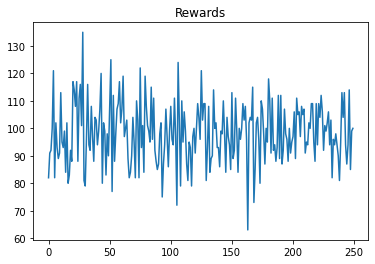

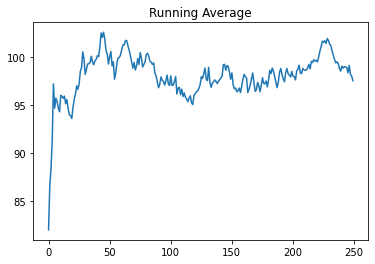

In [6]:
args = {'max_steps_per_episode': 100}

env = gym.make('StatelessHiring-v0', **args)
start_obs = env.reset()

play_n_episodes(env, model, n=250)

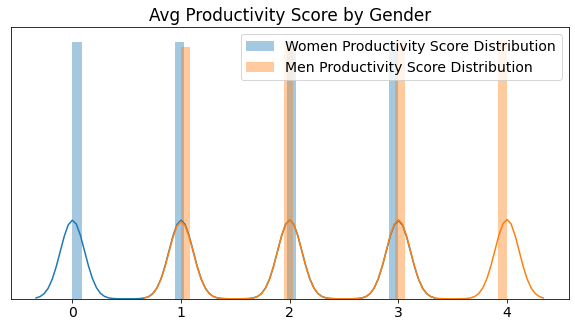

In [7]:
plt.rc('font', size=14)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.distplot(np.random.randint(WOM_LOW, WOM_HIGH, 100_000), ax=ax, label='Women Productivity Score Distribution')
sns.distplot(np.random.randint(MEN_LOW, MEN_HIGH, 100_000), ax=ax, label='Men Productivity Score Distribution')

ax.legend()
ax.set_title('Avg Productivity Score by Gender')
ax.set_yticks([])
pass

AttributeError: 'StatelessHiring' object has no attribute 'attr_hire_counts'

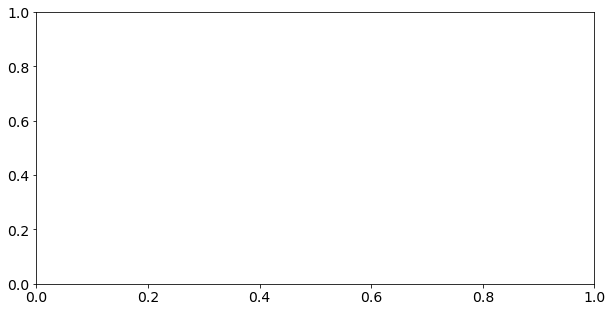

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(0, env.attr_hire_counts[0][0], label='Women Hired')
ax.bar(1, env.attr_hire_counts[0][1], label='Men Hired')
ax.legend()
hire_rate = 100*np.sum(np.sum(env.action_episode_memory)) / (N*100)
ax.set_title('Number candidates hired by gender when hiring top {:.2f}% of candidates'.format(hire_rate))
pass

# Use IRL to compute reward function from optimal policy

In [9]:
from experiments.irl.linear_irl import irl

learned_reward = irl(env.n_states, env.n_actions, env.transition_probabilities, model.policy, 0, 4, 0)
learned_reward

Optimal solution found.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Learn new policy using learned reward (Value Iteration)

# Execute new policy

# Evaluate new policy